In [1]:
# MUST be the first cell in the notebook
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from utils import train_model, evaluate_model
import torch.optim as optim
import sys
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [2]:
def set_seed(seed=0):
    print('Deterministic code, set seed to', seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 6
set_seed(seed=seed)

Deterministic code, set seed to 6


#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 8 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [3]:
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [4]:
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=4d298e12-77b5-459d-a46f-8af2584dff78
To: /content/IT_data.h5
100%|██████████| 384M/384M [00:11<00:00, 32.7MB/s]


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


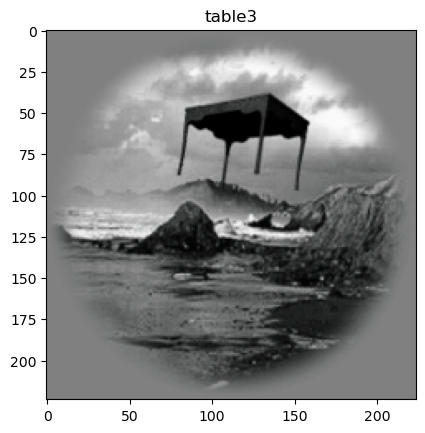

In [ ]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

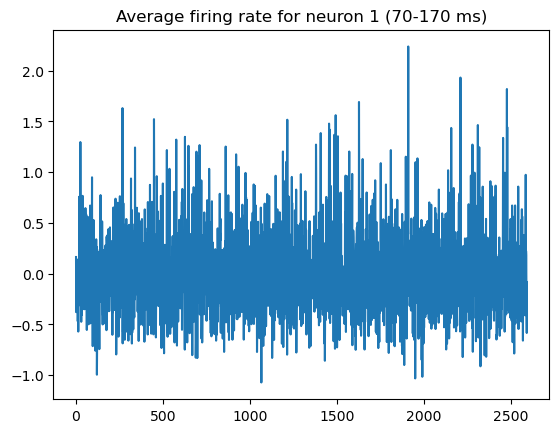

In [ ]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

---

## Optimize your current models by adjusting hyperparameters and implementing different regularizations.

The first thing that we tried here is to change the normalization method so that it fits the statistics of our images and slightly change the scheduler so that the learning rate change by a 0.6 factor every 10 epochs and run for 20 epochs. This 0.6 factor every 10 epochs has been found by noticing that the model tend to converge slower at first than the model initilialized with the normalization of resnet50 (Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])).

First of all, for comparison purposes, let's retrain the original model

### _Retrain original model_

In [5]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [6]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset_original = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset_original = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset_original = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader_original = DataLoader(train_dataset_original, batch_size=32, shuffle=True, num_workers=0)
val_dataloader_original = DataLoader(val_dataset_original, batch_size=32, shuffle=False)
test_dataloader_original = DataLoader(test_dataset_original, batch_size=32, shuffle=False)

In [7]:
class ShallowCNN(nn.Module):
    def __init__(self, n_neurons):
        """
        Shallow CNN for IT neural activity prediction.

        Args:
            n_neurons (int): Number of output neurons (matches the number of IT neurons).
        """
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(32 * 56 * 56, 128)
        self.output = nn.Linear(128, n_neurons)

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.output(x)
        return x

# Initialize the model
n_neurons = spikes_train.shape[1]
shallow_cnn = ShallowCNN(n_neurons=n_neurons)

In [8]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn.parameters(), lr=learning_rate)

In [9]:
#Uses original scheduler
train_model(shallow_cnn, train_dataloader_original, val_dataloader_original, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.8407, Val Loss: 0.1413
Epoch 2/15, Train Loss: 0.1360, Val Loss: 0.1409
Epoch 3/15, Train Loss: 0.1346, Val Loss: 0.1366
Epoch 4/15, Train Loss: 0.1273, Val Loss: 0.1246
Epoch 5/15, Train Loss: 0.1159, Val Loss: 0.1170
Epoch 6/15, Train Loss: 0.1040, Val Loss: 0.1146
Epoch 7/15, Train Loss: 0.1013, Val Loss: 0.1137
Epoch 8/15, Train Loss: 0.0994, Val Loss: 0.1133
Epoch 9/15, Train Loss: 0.0977, Val Loss: 0.1130
Epoch 10/15, Train Loss: 0.0958, Val Loss: 0.1128
Epoch 11/15, Train Loss: 0.0942, Val Loss: 0.1128
Epoch 12/15, Train Loss: 0.0939, Val Loss: 0.1128
Epoch 13/15, Train Loss: 0.0937, Val Loss: 0.1129
Epoch 14/15, Train Loss: 0.0936, Val Loss: 0.1129
Epoch 15/15, Train Loss: 0.0934, Val Loss: 0.1130


[Current Model] Overall explained variance: 0.1732
[Current Model] Overall correlation: 0.4002


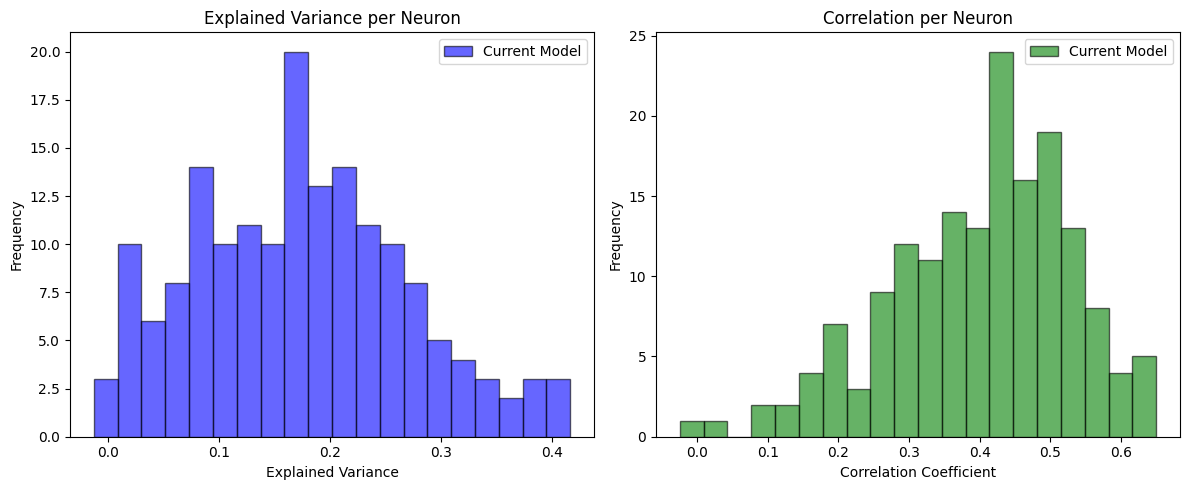

In [10]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn, val_dataloader_original, spikes_val, device="cpu")

### _Normalization + scheduler change_

In [11]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [12]:
means = stimulus_train.mean(axis=(0, 2, 3))  # mean over channels
stds = stimulus_train.std(axis=(0, 2, 3))    # std over channels

print("Dataset means:", means)
print("Dataset stds:", stds)

transform = transforms.Compose([
    transforms.Normalize(mean=means.tolist(), std=stds.tolist())
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset means: [-0.16872346 -0.04302491  0.1793886 ]
Dataset stds: [0.78718233 0.8047593  0.8011816 ]


In [13]:
shallow_cnn_norm = ShallowCNN(n_neurons=n_neurons)

In [14]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn_norm.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [15]:
train_model(shallow_cnn_norm, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.1561, Val Loss: 0.1399
Epoch 2/20, Train Loss: 0.1327, Val Loss: 0.1337
Epoch 3/20, Train Loss: 0.1226, Val Loss: 0.1212
Epoch 4/20, Train Loss: 0.1055, Val Loss: 0.1141
Epoch 5/20, Train Loss: 0.0938, Val Loss: 0.1113
Epoch 6/20, Train Loss: 0.0873, Val Loss: 0.1128
Epoch 7/20, Train Loss: 0.0833, Val Loss: 0.1113
Epoch 8/20, Train Loss: 0.0810, Val Loss: 0.1112
Epoch 9/20, Train Loss: 0.0790, Val Loss: 0.1095
Epoch 10/20, Train Loss: 0.0764, Val Loss: 0.1099
Epoch 11/20, Train Loss: 0.0737, Val Loss: 0.1092
Epoch 12/20, Train Loss: 0.0717, Val Loss: 0.1087
Epoch 13/20, Train Loss: 0.0704, Val Loss: 0.1091
Epoch 14/20, Train Loss: 0.0696, Val Loss: 0.1089
Epoch 15/20, Train Loss: 0.0689, Val Loss: 0.1088
Epoch 16/20, Train Loss: 0.0682, Val Loss: 0.1091
Epoch 17/20, Train Loss: 0.0677, Val Loss: 0.1093
Epoch 18/20, Train Loss: 0.0673, Val Loss: 0.1090
Epoch 19/20, Train Loss: 0.0671, Val Loss: 0.1089
Epoch 20/20, Train Loss: 0.0667, Val Loss: 0.1094


[Current Model] Overall explained variance: 0.1961
[Current Model] Overall correlation: 0.4362
[Previous Model] Overall explained variance: 0.1732
[Previous Model] Overall correlation: 0.4002


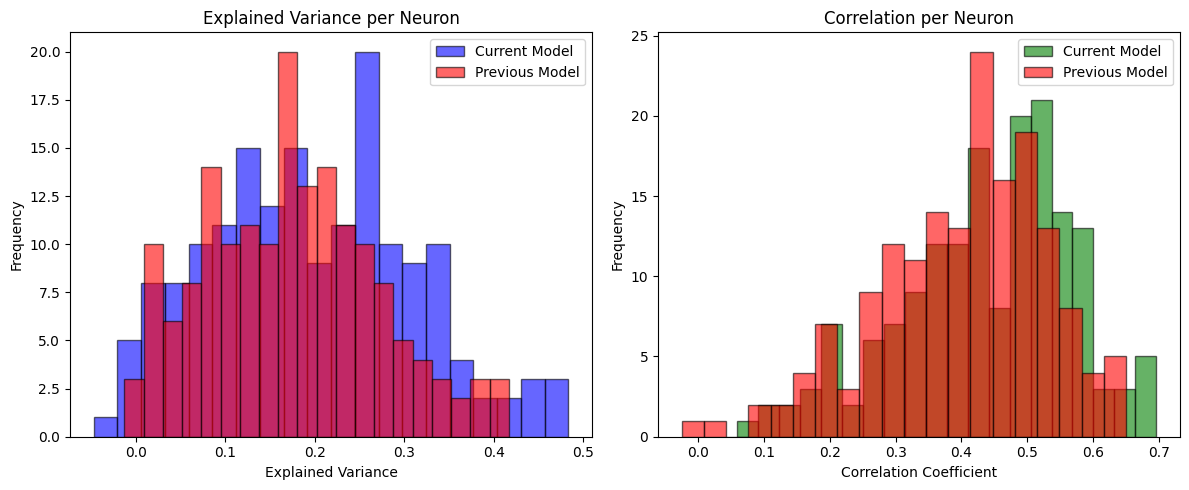

In [16]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn_norm, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn, prev_dataloader=val_dataloader_original)

---

Here we notice a slight improvement compared to the original model, where the overall explained variance increased from 0.1732 to 0.1961, and the overall correlation improved from 0.4002 to 0.4362. This suggests that the changes made, such as normalization adjustment and scheduler modification, are beneficial. Let's continue optimizing the method further to achieve even better results.

---

### _Dropout regularization change_

What we tried next is to decrease the dropout rate. We decided to set to 0.2

In [17]:
class ShallowCNN(nn.Module):
    def __init__(self, n_neurons):
        """
        Shallow CNN for IT neural activity prediction.

        Args:
            n_neurons (int): Number of output neurons (matches the number of IT neurons).
        """
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Change
        self.fc = nn.Linear(32 * 56 * 56, 128)
        self.output = nn.Linear(128, n_neurons)

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.output(x)
        return x

In [18]:
shallow_cnn_drop = ShallowCNN(n_neurons=n_neurons)
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn_drop.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [19]:
train_model(shallow_cnn_drop, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.2780, Val Loss: 0.1412
Epoch 2/20, Train Loss: 0.1360, Val Loss: 0.1409
Epoch 3/20, Train Loss: 0.1328, Val Loss: 0.1301
Epoch 4/20, Train Loss: 0.1164, Val Loss: 0.1161
Epoch 5/20, Train Loss: 0.0997, Val Loss: 0.1154
Epoch 6/20, Train Loss: 0.0904, Val Loss: 0.1129
Epoch 7/20, Train Loss: 0.0852, Val Loss: 0.1124
Epoch 8/20, Train Loss: 0.0818, Val Loss: 0.1128
Epoch 9/20, Train Loss: 0.0793, Val Loss: 0.1123
Epoch 10/20, Train Loss: 0.0776, Val Loss: 0.1124
Epoch 11/20, Train Loss: 0.0761, Val Loss: 0.1113
Epoch 12/20, Train Loss: 0.0744, Val Loss: 0.1118
Epoch 13/20, Train Loss: 0.0735, Val Loss: 0.1116
Epoch 14/20, Train Loss: 0.0726, Val Loss: 0.1119
Epoch 15/20, Train Loss: 0.0719, Val Loss: 0.1117
Epoch 16/20, Train Loss: 0.0713, Val Loss: 0.1115
Epoch 17/20, Train Loss: 0.0707, Val Loss: 0.1120
Epoch 18/20, Train Loss: 0.0700, Val Loss: 0.1114
Epoch 19/20, Train Loss: 0.0693, Val Loss: 0.1114
Epoch 20/20, Train Loss: 0.0685, Val Loss: 0.1110


[Current Model] Overall explained variance: 0.1801
[Current Model] Overall correlation: 0.4196
[Previous Model] Overall explained variance: 0.1961
[Previous Model] Overall correlation: 0.4362


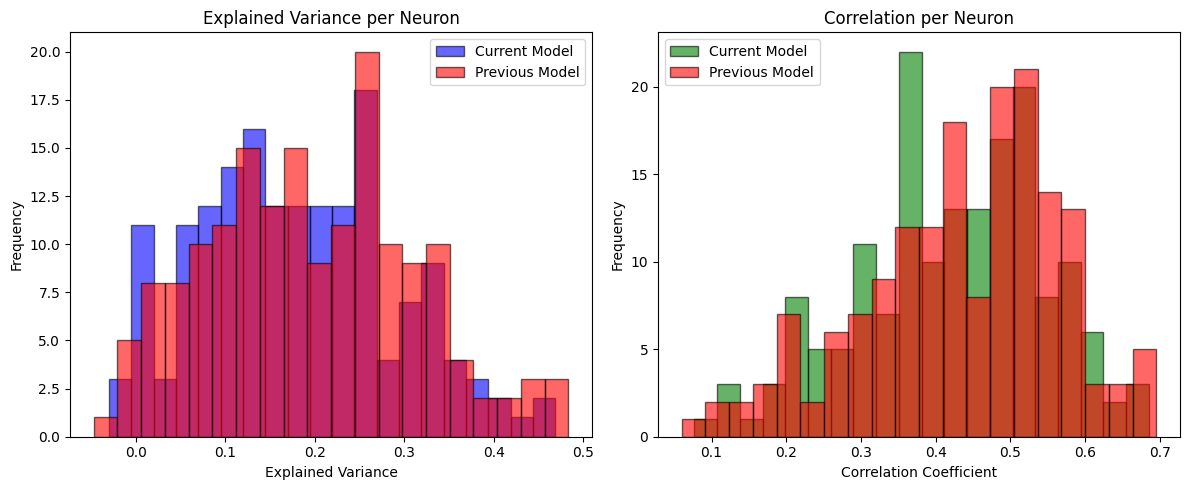

In [20]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn_drop, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn_norm, prev_dataloader=val_dataloader)

---

As shown here, adjusting the dropout rate to 0.2 led to a slight decline in performance—EV decreased from 0.1961 to 0.1801, and correlation decreased from 0.4362 to 0.4196. The dropout prevents the network from becoming too dependent on specific patterns. The idea comes from the fact that we thought that the dropout might decrease the representation power of the network. Moreover, the dropout being a parameter that helps smoothen convergence, it caused instability during training, requiring us to rerun the training three times before achieving convergence, as the other two attempts resulted in divergence during gradient descent. Even in the previous trainings, from time to time, the model fails to coverge to its minimal value and either diverges or stagnates to a local minimum. This motivates or choice to add L2 regularization.

---

### _Dropout regularization change + L2 regularization_

To solve those problems, we decided to add a little of L2 regularization inside of the optimizer (weight_decay=1e-5). The motivation for reducing the dropout is that the risk with the dropout might lead to not using the model to its full potential. The motivation of setting a weight_decay is that we still want some sort of regularization.

In [21]:
shallow_cnn_l2 = ShallowCNN(n_neurons=n_neurons)

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(shallow_cnn_l2.parameters(), lr=learning_rate, weight_decay=1e-5)  # Change
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [22]:
train_model(shallow_cnn_l2, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.1994, Val Loss: 0.1414
Epoch 2/20, Train Loss: 0.1360, Val Loss: 0.1410
Epoch 3/20, Train Loss: 0.1358, Val Loss: 0.1410
Epoch 4/20, Train Loss: 0.1348, Val Loss: 0.1381
Epoch 5/20, Train Loss: 0.1288, Val Loss: 0.1228
Epoch 6/20, Train Loss: 0.1117, Val Loss: 0.1142
Epoch 7/20, Train Loss: 0.0959, Val Loss: 0.1116
Epoch 8/20, Train Loss: 0.0870, Val Loss: 0.1110
Epoch 9/20, Train Loss: 0.0815, Val Loss: 0.1105
Epoch 10/20, Train Loss: 0.0776, Val Loss: 0.1092
Epoch 11/20, Train Loss: 0.0731, Val Loss: 0.1085
Epoch 12/20, Train Loss: 0.0697, Val Loss: 0.1079
Epoch 13/20, Train Loss: 0.0677, Val Loss: 0.1080
Epoch 14/20, Train Loss: 0.0660, Val Loss: 0.1078
Epoch 15/20, Train Loss: 0.0643, Val Loss: 0.1078
Epoch 16/20, Train Loss: 0.0624, Val Loss: 0.1081
Epoch 17/20, Train Loss: 0.0613, Val Loss: 0.1085
Epoch 18/20, Train Loss: 0.0603, Val Loss: 0.1081
Epoch 19/20, Train Loss: 0.0594, Val Loss: 0.1088
Epoch 20/20, Train Loss: 0.0581, Val Loss: 0.1078


[Current Model] Overall explained variance: 0.2081
[Current Model] Overall correlation: 0.4526
[Previous Model] Overall explained variance: 0.1801
[Previous Model] Overall correlation: 0.4196


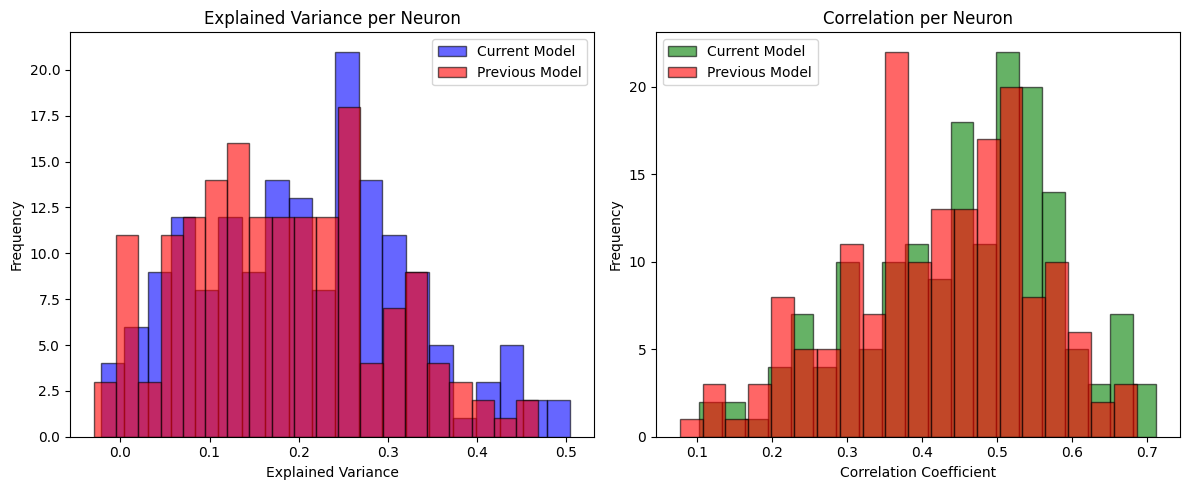

In [23]:
# Evaluate model on the validation set
evaluate_model(shallow_cnn_l2, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn_drop, prev_dataloader=val_dataloader)

---

We can see a very subtle improvement, with the overall explained variance decreasing to 0.2081 and the overall correlation improving to 0.4526. The main thing about L2 regularization is that it helped us converge almost all of the time. However, we deduced from our results that the model is likely not expressive enough, and to improve performance, we would need a model with more parameters or a different architecture.

---

### _Update of architecture_

The goal of this part is to add a layer to the architecture and see if it adds anything to the performance of the model. Here we add one convilutionnal layer.

In [24]:
class DeeperCNN(nn.Module):
    def __init__(self, n_neurons):
        """
        Shallow CNN for IT neural activity prediction.

        Args:
            n_neurons (int): Number of output neurons (matches the number of IT neurons).
        """
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Change
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(64 * 28 * 28, 128)
        self.output = nn.Linear(128, n_neurons)

    def forward(self, x):
        """
        Forward pass of the model.
        """
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))  # Change
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.output(x)
        return x

In [25]:
# Initialize the model
n_neurons = spikes_train.shape[1]
deeper_cnn = DeeperCNN(n_neurons=n_neurons)

In [26]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(deeper_cnn.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)

In [27]:
train_model(deeper_cnn, train_dataloader, val_dataloader, loss_function, optimizer, epochs=20, device=device, scheduler=scheduler)

Epoch 1/20, Train Loss: 0.1401, Val Loss: 0.1362
Epoch 2/20, Train Loss: 0.1241, Val Loss: 0.1215
Epoch 3/20, Train Loss: 0.1105, Val Loss: 0.1109
Epoch 4/20, Train Loss: 0.1011, Val Loss: 0.1089
Epoch 5/20, Train Loss: 0.0936, Val Loss: 0.1046
Epoch 6/20, Train Loss: 0.0873, Val Loss: 0.1038
Epoch 7/20, Train Loss: 0.0812, Val Loss: 0.1030
Epoch 8/20, Train Loss: 0.0771, Val Loss: 0.1043
Epoch 9/20, Train Loss: 0.0739, Val Loss: 0.1044
Epoch 10/20, Train Loss: 0.0712, Val Loss: 0.1048
Epoch 11/20, Train Loss: 0.0681, Val Loss: 0.1041
Epoch 12/20, Train Loss: 0.0657, Val Loss: 0.1052
Epoch 13/20, Train Loss: 0.0644, Val Loss: 0.1055
Epoch 14/20, Train Loss: 0.0635, Val Loss: 0.1068
Epoch 15/20, Train Loss: 0.0628, Val Loss: 0.1068
Epoch 16/20, Train Loss: 0.0623, Val Loss: 0.1075
Epoch 17/20, Train Loss: 0.0618, Val Loss: 0.1069
Epoch 18/20, Train Loss: 0.0616, Val Loss: 0.1081
Epoch 19/20, Train Loss: 0.0613, Val Loss: 0.1078
Epoch 20/20, Train Loss: 0.0608, Val Loss: 0.1092


[Current Model] Overall explained variance: 0.2043
[Current Model] Overall correlation: 0.4620
[Previous Model] Overall explained variance: 0.2081
[Previous Model] Overall correlation: 0.4526


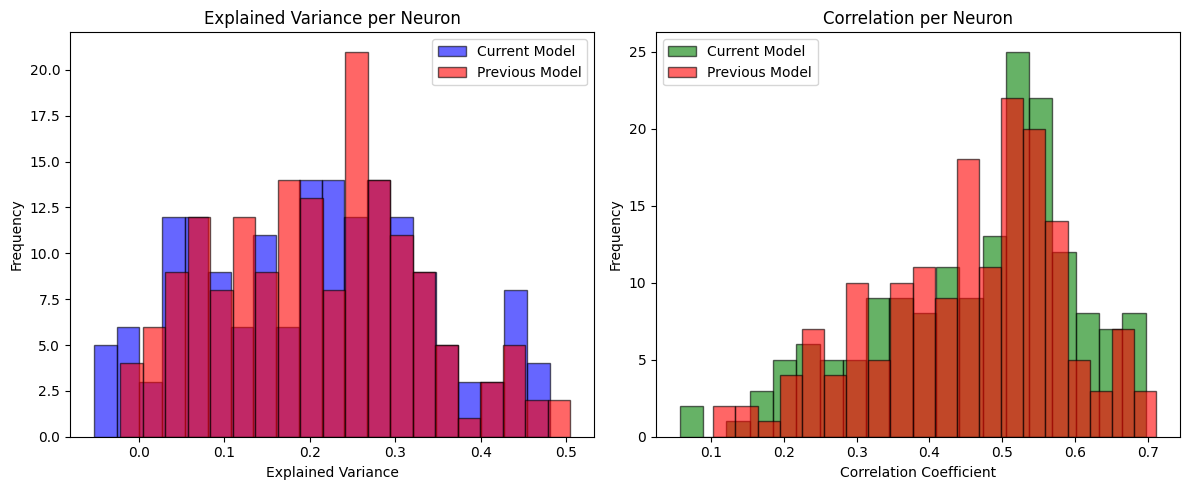

In [28]:
# Evaluate model on the validation set
evaluate_model(deeper_cnn, val_dataloader, spikes_val, device="cpu",
               prev_model=shallow_cnn_l2, prev_dataloader=val_dataloader)

---

We notice a slight improvement, with the overall explained variance decreasing to 0.2043 but the overall correlation improving to 0.4620. This suggests that our models are still not expressive enough, making it worthwhile to explore the use of pretrained models, which will be addressed in the following section.

---

## Employ a pretrained neural network and finetune it

In this section, we'll try to train 4 models

- CNN model:
    - ResNet50
    - efficientnet_b5 (a bit bigger than ResNet50 and a bit more of parameters)

- Vision transfomers:
    - vit_base_patch16_224
    - vit_tiny_patch16_224

### _ResNet50_

In [29]:
# Make sure were using the fastest option:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [30]:
# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset_res = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset_res = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset_res = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader_res = DataLoader(train_dataset_res, batch_size=32, shuffle=True)
val_dataloader_res = DataLoader(val_dataset_res, batch_size=32, shuffle=False)
test_dataloader_res = DataLoader(test_dataset_res, batch_size=32, shuffle=False)

In [31]:
# Load Pretrained ResNet50
resnet = models.resnet50(pretrained=True)
# Change the last linear layer to match the number of neurons in the dataset
# Note: The number of neurons in the dataset is 168
resnet.fc = nn.Linear(resnet.fc.in_features, 168)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


In [32]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

In [33]:
# Train model
train_model(resnet, train_dataloader_res, val_dataloader_res, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1408, Val Loss: 0.1317
Epoch 2/15, Train Loss: 0.1164, Val Loss: 0.1273
Epoch 3/15, Train Loss: 0.1064, Val Loss: 0.1096
Epoch 4/15, Train Loss: 0.0947, Val Loss: 0.0988
Epoch 5/15, Train Loss: 0.0855, Val Loss: 0.0890
Epoch 6/15, Train Loss: 0.0735, Val Loss: 0.0779
Epoch 7/15, Train Loss: 0.0699, Val Loss: 0.0764
Epoch 8/15, Train Loss: 0.0675, Val Loss: 0.0755
Epoch 9/15, Train Loss: 0.0653, Val Loss: 0.0744
Epoch 10/15, Train Loss: 0.0628, Val Loss: 0.0744
Epoch 11/15, Train Loss: 0.0598, Val Loss: 0.0725
Epoch 12/15, Train Loss: 0.0593, Val Loss: 0.0724
Epoch 13/15, Train Loss: 0.0589, Val Loss: 0.0722
Epoch 14/15, Train Loss: 0.0582, Val Loss: 0.0721
Epoch 15/15, Train Loss: 0.0579, Val Loss: 0.0719


[Current Model] Overall explained variance: 0.4231
[Current Model] Overall correlation: 0.6379
[Previous Model] Overall explained variance: 0.2043
[Previous Model] Overall correlation: 0.4620


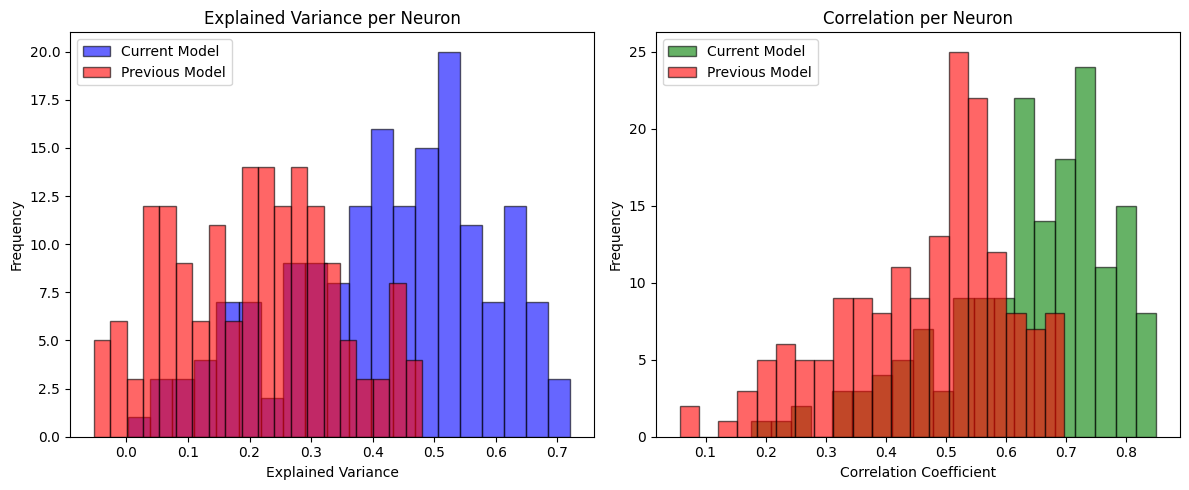

In [34]:
# Evaluate model on the validation set
evaluate_model(resnet, val_dataloader_res, spikes_val, device="cpu",
               prev_model=deeper_cnn, prev_dataloader=val_dataloader)

---

All right! The explained variance improved significantly to 0.4231, and the correlation coefficient increased to 0.6379. This is a substantial improvement, showing that using a pretrained ResNet50 is highly promising. Let's try another model to see if we can achieve even better results.

---

### _efficientnet_b5_

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [36]:
from timm import create_model
eff_res = create_model('efficientnet_b5', pretrained=True)
# Replace the final classifier layer to output 168 neurons
eff_res.classifier = nn.Linear(eff_res.classifier.in_features, 168)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

In [37]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(eff_res.parameters(), lr=learning_rate)

In [38]:
train_model(eff_res, train_dataloader_res, val_dataloader_res, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1113, Val Loss: 0.1128
Epoch 2/15, Train Loss: 0.0889, Val Loss: 0.0895
Epoch 3/15, Train Loss: 0.0805, Val Loss: 0.0896
Epoch 4/15, Train Loss: 0.0738, Val Loss: 0.0777
Epoch 5/15, Train Loss: 0.0691, Val Loss: 0.0798
Epoch 6/15, Train Loss: 0.0590, Val Loss: 0.0662
Epoch 7/15, Train Loss: 0.0535, Val Loss: 0.0652
Epoch 8/15, Train Loss: 0.0510, Val Loss: 0.0646
Epoch 9/15, Train Loss: 0.0488, Val Loss: 0.0645
Epoch 10/15, Train Loss: 0.0472, Val Loss: 0.0644
Epoch 11/15, Train Loss: 0.0449, Val Loss: 0.0642
Epoch 12/15, Train Loss: 0.0440, Val Loss: 0.0642
Epoch 13/15, Train Loss: 0.0438, Val Loss: 0.0643
Epoch 14/15, Train Loss: 0.0436, Val Loss: 0.0643
Epoch 15/15, Train Loss: 0.0431, Val Loss: 0.0644


[Current Model] Overall explained variance: 0.4642
[Current Model] Overall correlation: 0.6706
[Previous Model] Overall explained variance: 0.4231
[Previous Model] Overall correlation: 0.6379


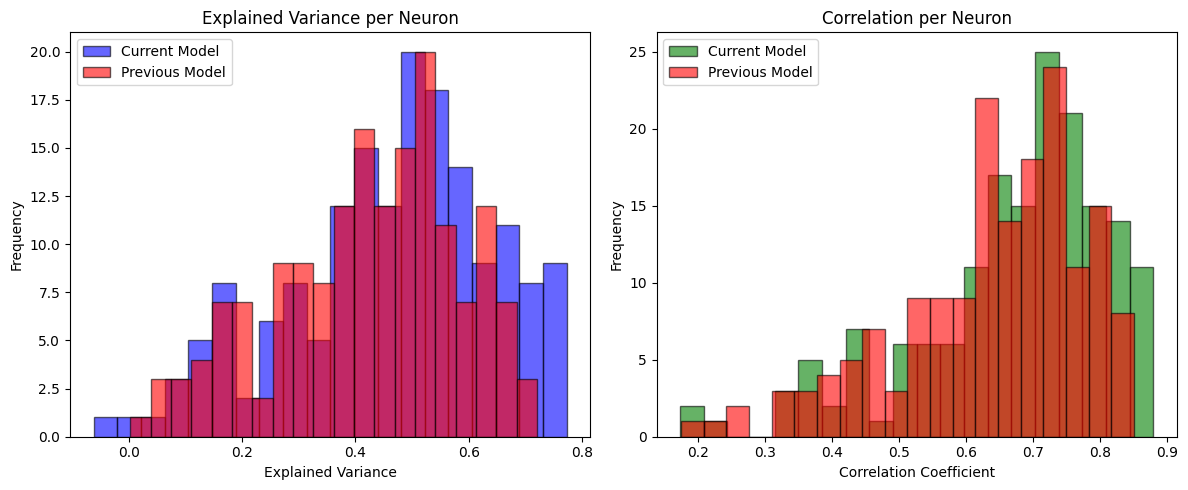

In [39]:
evaluate_model(eff_res, val_dataloader_res, spikes_val, device="cpu",
               prev_model=resnet, prev_dataloader=val_dataloader_res)

In [40]:
from utils import evaluate_model_main_comp

[Current Model] Overall explained variance: 0.4642
[Current Model] Overall correlation: 0.6706
[Previous Model] Overall explained variance: 0.4231
[Previous Model] Overall correlation: 0.6379
[First Model] Overall explained variance: 0.2043
[First Model] Overall correlation: 0.4620


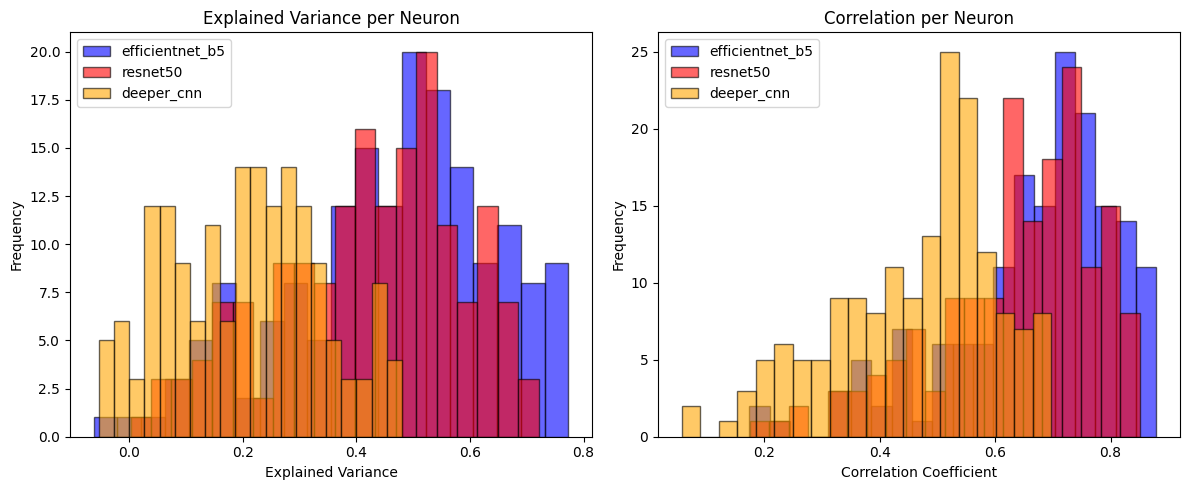

In [41]:
evaluate_model_main_comp(eff_res, val_dataloader_res, spikes_val, "cpu", resnet, val_dataloader_res, deeper_cnn, val_dataloader)

In [42]:
torch.save(eff_res.state_dict(), 'efficientnet_b5.pth')

---

The overall explained variance increased to 0.4642, and the overall correlation improved to 0.6706. As an intermediate conclusion, the slightly larger size (~100MB for ResNet50 and ~120MB for EfficientNet-B5) and the more recent architecture of EfficientNet-B5 provide a slight improvement in performance. This improvement is not a huge gap compared to resnet50, but is still significant as we can see on the graph right above. Another promising direction to explore is transformer models.

---

### _vit_base_patch16_224 (Vision transformer)_

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [44]:
from timm import create_model

# Load a pretrained ViT model (e.g., base model)
vit_base = create_model('vit_base_patch16_224', pretrained=True)

# Replace the final classification head with a linear layer for 168 outputs
vit_base.head = nn.Linear(vit_base.head.in_features, 168)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [45]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(vit_base.parameters(), lr=learning_rate)

In [46]:
train_model(vit_base, train_dataloader_res, val_dataloader_res, loss_function, optimizer, epochs=10, device=device)

Epoch 1/10, Train Loss: 0.1921, Val Loss: 0.1426
Epoch 2/10, Train Loss: 0.1377, Val Loss: 0.1429
Epoch 3/10, Train Loss: 0.1362, Val Loss: 0.1392
Epoch 4/10, Train Loss: 0.1351, Val Loss: 0.1380
Epoch 5/10, Train Loss: 0.1342, Val Loss: 0.1377
Epoch 6/10, Train Loss: 0.1301, Val Loss: 0.1334
Epoch 7/10, Train Loss: 0.1292, Val Loss: 0.1330
Epoch 8/10, Train Loss: 0.1287, Val Loss: 0.1337
Epoch 9/10, Train Loss: 0.1288, Val Loss: 0.1324
Epoch 10/10, Train Loss: 0.1279, Val Loss: 0.1323


[Current Model] Overall explained variance: 0.0569
[Current Model] Overall correlation: 0.2196
[Previous Model] Overall explained variance: 0.4642
[Previous Model] Overall correlation: 0.6706


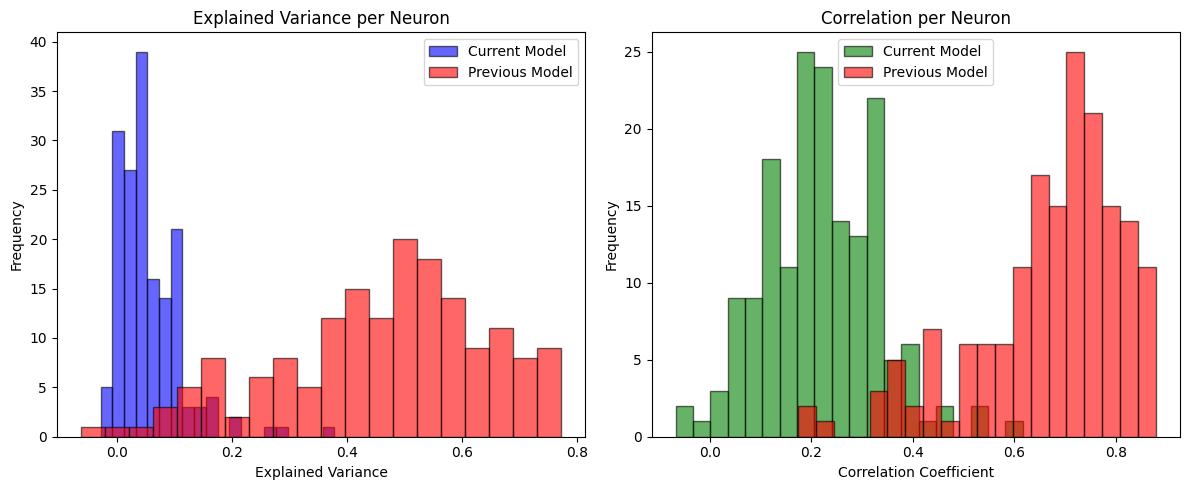

In [47]:
evaluate_model(vit_base, val_dataloader_res, spikes_val, device="cpu",
               prev_model=eff_res, prev_dataloader=val_dataloader_res)

---

As we can see here, using a vision transformer leads to a terrible performance. We then try to use vit_tiny, thinking that possibly the size of our dataset is too small compare to the size of the transformer model, knowing that transformer models often require more data to train than CNN models.

---

### _vit_tiny_patch16_224 (Vision transformer)_

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [49]:
from timm import create_model

# Load a pretrained ViT model (e.g., base model)
vit_tiny = create_model('vit_tiny_patch16_224', pretrained=True)

# Replace the final classification head with a linear layer for 168 outputs
vit_tiny.head = nn.Linear(vit_tiny.head.in_features, 168)

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [50]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(vit_tiny.parameters(), lr=learning_rate)

In [51]:
train_model(vit_tiny, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.3314, Val Loss: 0.1462
Epoch 2/15, Train Loss: 0.1383, Val Loss: 0.1420
Epoch 3/15, Train Loss: 0.1376, Val Loss: 0.1390
Epoch 4/15, Train Loss: 0.1358, Val Loss: 0.1378
Epoch 5/15, Train Loss: 0.1333, Val Loss: 0.1386
Epoch 6/15, Train Loss: 0.1255, Val Loss: 0.1305
Epoch 7/15, Train Loss: 0.1211, Val Loss: 0.1267
Epoch 8/15, Train Loss: 0.1148, Val Loss: 0.1240
Epoch 9/15, Train Loss: 0.1094, Val Loss: 0.1191
Epoch 10/15, Train Loss: 0.1029, Val Loss: 0.1179
Epoch 11/15, Train Loss: 0.0957, Val Loss: 0.1147
Epoch 12/15, Train Loss: 0.0939, Val Loss: 0.1149
Epoch 13/15, Train Loss: 0.0929, Val Loss: 0.1147
Epoch 14/15, Train Loss: 0.0919, Val Loss: 0.1144
Epoch 15/15, Train Loss: 0.0911, Val Loss: 0.1141


[Current Model] Overall explained variance: -0.2905
[Current Model] Overall correlation: 0.0892
[Previous Model] Overall explained variance: 0.4642
[Previous Model] Overall correlation: 0.6706


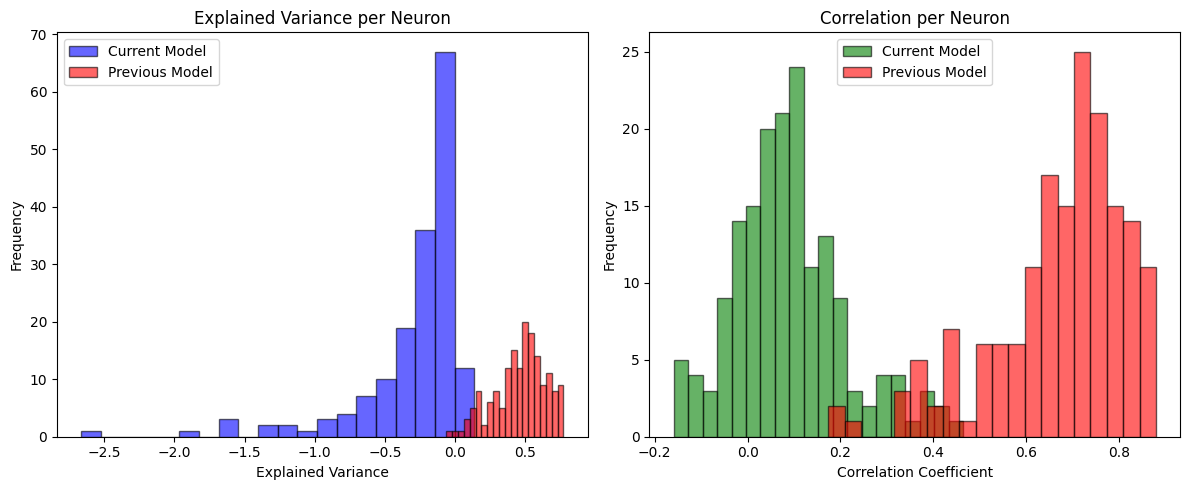

In [52]:
evaluate_model(vit_tiny, val_dataloader_res, spikes_val, device="cpu",
               prev_model=eff_res, prev_dataloader=val_dataloader_res)

---

The performance here is even worse. It looks like the model is not able to predict any neural activity at all. Neural activity in the brain, especially early visual areas like V1, is highly localized and sensitive to spatial structure. Hence, due to the difference of architecture that makes ViTs not assuming locality the same way, they might fail to capture the kinds of spatial features that are actually predictive of neural responses.

---

## Train a neural network for object recognition while predicting neural activity.

In this section, we'll train two model. For both models, we'll finetune ResNet50 using two objectives. The difference between the two models is how we'll balance the two objectives

1. Give the same weight (in term on how we balance) between both models
2. Give 0.3 coeff for the label prediction objective and 1 coeff to neural activity objective

### _Equal weight to both objectives_

In [53]:
number_classes = np.unique(objects_train).shape[0]
print('Number of classes in the dataset: {}'.format(number_classes))

Number of classes in the dataset: 64


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [55]:
print(objects_train)

['face6', 'table3', 'face3', 'face2', 'lioness', 'turtle', 'turtle', 'airplane3', 'cow', 'car_alfa', 'table2', 'ship1', 'car_bora', 'airplane3', 'face6', 'chair4', 'airplane0', 'airplane6', 'chair2', 'car_alfa', 'gorilla', 'chair4', 'raspberry', 'pear', 'chair5', 'face0', 'table5', 'table1', 'airplane5', 'airplane2', 'table7', 'chair0', 'chair7', 'face7', 'car_beetle', 'ship7', 'table0', 'chair7', 'airplane4', 'car_z3', 'chair7', 'lioness', 'table5', 'walnut', 'chair5', 'chair4', 'chair3', 'elephant', 'car_alfa', 'table4', 'car_clio', 'ship2', 'apple', 'airplane2', 'face1', 'chair7', 'watermelon', 'airplane0', 'walnut', 'watermelon', 'dog', 'airplane7', 'ship1', 'apple', 'ship7', 'ship6', 'ship2', 'pear', 'car_bmw', 'car_alfa', 'face0', 'ship1', 'ship7', 'table1', 'car_bora', 'car_alfa', 'watermelon', 'pear', 'car_celica', 'apple', 'chair7', 'table0', 'car_clio', 'airplane7', 'car_beetle', 'apricot', 'table1', 'chair0', 'car_bora', 'hedgehog', 'ship6', 'airplane4', 'chair2', 'car_z3', 

In [56]:
def string_to_label(objects, label_dict):
    """
    Convert object names to labels.

    Args:
        objects (numpy array): Array of object names.

    Returns:
        numpy array: Array of labels corresponding to the object names.
    """
    labels = np.array([label_dict[obj] for obj in objects])
    return labels

In [57]:
# Outputs the unique labels for the objects
unique_objects = np.unique(objects_train)
# Create a dictionary to map object names to labels
label_dict = {obj: idx for idx, obj in enumerate(unique_objects)}

# Convert object names to labels
objects_train_labels = string_to_label(objects_train, label_dict)
objects_val_labels = string_to_label(objects_val, label_dict)
objects_test_labels = string_to_label(objects_test, label_dict)

In [58]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, objects=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction with additional objects info.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            objects (numpy array, optional): Additional information (e.g., object labels). Default is None.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.objects = torch.from_numpy(objects).long() if objects is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None
        object_info = self.objects[idx] if self.objects is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        # Return the image, neural activity, and object info if available
        if neural_activity is not None and object_info is not None:
            return img, neural_activity, object_info
        else:
            return img

# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset_bi = ITNeuralActivity(stimulus_train, spikes_train, objects_train_labels, transform=transform)
val_dataset_bi = ITNeuralActivity(stimulus_val, spikes_val, objects_val_labels, transform=transform)
test_dataset_bi = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader_bi = DataLoader(train_dataset_bi, batch_size=32, shuffle=True)
val_dataloader_bi = DataLoader(val_dataset_bi, batch_size=32, shuffle=False)
test_dataloader_bi = DataLoader(test_dataset_bi, batch_size=32, shuffle=False)

In [59]:
class MultiTaskModel(nn.Module):
    def __init__(self, base_model):
        super(MultiTaskModel, self).__init__()

        # Remove the final fully connected layer (fc)
        self.base_model = base_model
        self.base_model.fc = nn.Identity()

        # Forward pass through the model with a dummy input to get the feature map size
        dummy_input = torch.zeros(1, 3, 224, 224)  # Example input with batch size 1 and 3 RGB channels
        with torch.no_grad():
            features = self.base_model(dummy_input)

        # Get the size of the features from the last convolutional block
        # We need this because the model has to have a fc_in_features that matches the output of the base model
        self.fc_in_features = features.numel()  # This will give us the flattened size

        # Task-specific heads
        self.task1_head = nn.Linear(self.fc_in_features, 168)  # For continuous output (neural activity)
        self.task2_head = nn.Linear(self.fc_in_features, 64)   # For classification (64 classes in our case)

    def forward(self, x):
        # Shared layers
        features = self.base_model(x)  # Output from ResNet (before the last fully connected layer)

        # Flatten the features to pass to the heads
        features = features.view(features.size(0), -1)  # Flatten the feature map

        # Task-specific outputs
        task1_output = self.task1_head(features)
        task2_output = self.task2_head(features)

        return task1_output, task2_output

# Load the ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Instantiate the multi-task model
model_multi_1 = MultiTaskModel(resnet50)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
criterion_activity = nn.MSELoss()  # For continuous neural activity
criterion_label = nn.CrossEntropyLoss()  # For classification task

learning_rate = 0.001
optimizer = optim.Adam(model_multi_1.parameters(), lr=learning_rate)

In [61]:
from utils import train_model_biobj

In [62]:
# Train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
coef_label = 1
train_model_biobj(model_multi_1, train_dataloader_bi, val_dataloader_bi, criterion_activity, criterion_label, coef_label, optimizer, epochs=20, device=device)

Epoch 1/20, Train Loss: 3.7551, Val Loss: 3.8154
Epoch 2/20, Train Loss: 2.7938, Val Loss: 10.0914
Epoch 3/20, Train Loss: 2.4487, Val Loss: 2.2685
Epoch 4/20, Train Loss: 2.1739, Val Loss: 2.7336
Epoch 5/20, Train Loss: 1.9025, Val Loss: 2.1058
Epoch 6/20, Train Loss: 1.3413, Val Loss: 1.2532
Epoch 7/20, Train Loss: 1.0856, Val Loss: 1.1612
Epoch 8/20, Train Loss: 0.9654, Val Loss: 1.1075
Epoch 9/20, Train Loss: 0.8446, Val Loss: 1.0230
Epoch 10/20, Train Loss: 0.7103, Val Loss: 0.9727
Epoch 11/20, Train Loss: 0.6239, Val Loss: 0.9216
Epoch 12/20, Train Loss: 0.5916, Val Loss: 0.9128
Epoch 13/20, Train Loss: 0.5677, Val Loss: 0.9170
Epoch 14/20, Train Loss: 0.5530, Val Loss: 0.8999
Epoch 15/20, Train Loss: 0.5439, Val Loss: 0.9043
Epoch 16/20, Train Loss: 0.5391, Val Loss: 0.9018
Epoch 17/20, Train Loss: 0.5295, Val Loss: 0.8957
Epoch 18/20, Train Loss: 0.5395, Val Loss: 0.8961
Epoch 19/20, Train Loss: 0.5225, Val Loss: 0.8926
Epoch 20/20, Train Loss: 0.5232, Val Loss: 0.8979


---

For the first model, where we gave equal weight to both objectives, the overall explained variance was 0.1988, and the overall correlation was 0.4348 (as shown in the next graph of this notebook). The performance on training of both objectives seems to decrease compare to the original ResNet model, trained on the unique objective to predict neural activity. We then need to try to balance the objectives differently and study if it makes a difference in predicting neural activity.

---

### _Weight 0.3 to the label prediction objective & 1 to the neural activity objective_

Here we'll try to balance the objective a bit differently

In [64]:
# Train model
train_dataloader_bi = DataLoader(train_dataset_bi, batch_size=32, shuffle=True)
val_dataloader_bi = DataLoader(val_dataset_bi, batch_size=32, shuffle=False)
test_dataloader_bi = DataLoader(test_dataset_bi, batch_size=32, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
coef_label = 0.3
# Load the ResNet50 model
resnet50_03 = models.resnet50(pretrained=True)

# Instantiate the multi-task model
model_multi_0_3 = MultiTaskModel(resnet50_03)

criterion_activity = nn.MSELoss()  # For continuous neural activity
criterion_label = nn.CrossEntropyLoss()  # For classification task

learning_rate = 0.001
optimizer = optim.Adam(model_multi_0_3.parameters(), lr=learning_rate)

train_model_biobj(model_multi_0_3, train_dataloader_bi, val_dataloader_bi, criterion_activity, criterion_label, coef_label, optimizer, epochs=20, device=device)

Epoch 1/20, Train Loss: 1.0595, Val Loss: 1.1084
Epoch 2/20, Train Loss: 0.7920, Val Loss: 0.9835
Epoch 3/20, Train Loss: 0.6533, Val Loss: 0.7809
Epoch 4/20, Train Loss: 0.5669, Val Loss: 1.1424
Epoch 5/20, Train Loss: 0.5012, Val Loss: 1.1485
Epoch 6/20, Train Loss: 0.3448, Val Loss: 0.3510
Epoch 7/20, Train Loss: 0.2775, Val Loss: 0.3303
Epoch 8/20, Train Loss: 0.2530, Val Loss: 0.3302
Epoch 9/20, Train Loss: 0.2239, Val Loss: 0.3063
Epoch 10/20, Train Loss: 0.2014, Val Loss: 0.3080
Epoch 11/20, Train Loss: 0.1825, Val Loss: 0.2894
Epoch 12/20, Train Loss: 0.1770, Val Loss: 0.2911
Epoch 13/20, Train Loss: 0.1723, Val Loss: 0.2898
Epoch 14/20, Train Loss: 0.1721, Val Loss: 0.2907
Epoch 15/20, Train Loss: 0.1684, Val Loss: 0.2915
Epoch 16/20, Train Loss: 0.1665, Val Loss: 0.2883
Epoch 17/20, Train Loss: 0.1659, Val Loss: 0.2929
Epoch 18/20, Train Loss: 0.1670, Val Loss: 0.2889
Epoch 19/20, Train Loss: 0.1645, Val Loss: 0.2889
Epoch 20/20, Train Loss: 0.1647, Val Loss: 0.2867


Overall explained variance biobjective weight 1: 0.1988
Overall correlation biobjective weight 1: 0.4348
Overall explained variance biobjective weight 0.3: 0.3156
Overall correlation biobjective weight 0.3: 0.5506
Overall explained variance resnet: 0.4642
Overall correlation resnet: 0.6706


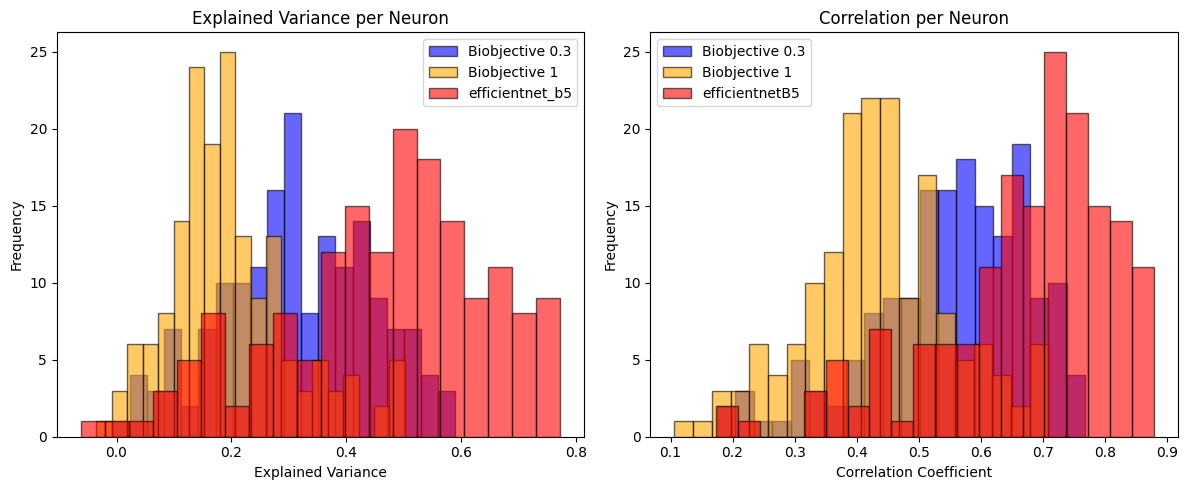

In [ ]:
from utils import evaluate_model_bi
evaluate_model_bi(model_multi_0_3, val_dataloader_bi, spikes_val, "cpu", model_multi_1, eff_res, val_dataloader_res)

---

For the second model, where we assigned a weight of 0.3 to the label prediction objective and 1 to the neural activity objective, the overall explained variance improved to 0.3156, and the overall correlation increased to 0.5506, suggesting that prioritizing the neural activity objective leads to better performance. Indeed, the original ResNet model, trained solely on predicting neural acitivity led to better performance, with an overall explained variance of 0.4642 and an overall correlation of 0.6706. The graphics suggest the idea that the less we train on the label prediction objective, the better the model is at predicting neural activity.

---